### Base Learner 9a  - Use Extreme WeightedDL
Can we get better perf on pieces we over-weight?

In [1]:
from fastai2.vision.all import *
import sys, torch
sys.path.append('..')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# %load_ext autoreload
# %autoreload 2

from modules.expbuilder import default_params, run_exp, rm_test_recorder

train_path = Path('../../../rf-chess-data/cropped_v1/')
train_clean_path = Path('../../../rf-chess-data/cropped_v1.1/')

test_path_all = Path('../../../other-chess-data/regulation-test-2-all/')
test_path_easy = Path('../../../other-chess-data/regulation-test-2-easy/')

In [2]:
def my_weight_func(it_path):
    return 10 if 'queen' in it_path.name else 1

In [3]:
my_params = {'_train_seed':0, '_custom_crop': 'my-top-crop', 
             '_model_arch': resnet50,
            '_train_path':train_clean_path,
            '_learn_norm': False,
             '_weighted_dl': True, 
             '_weight_func': my_weight_func,
             
            }
default_params.update(my_params)

In [4]:
set_seed(42)

In [5]:
train_dl, learn = run_exp(default_params, 'dummy', b_ret=True,)

In [6]:
set_seed(42)
with learn.no_logging(): learn.fit_one_cycle(10)

### Interpret and Compare

In [7]:
pd.DataFrame(learn.cbs[3].values)

,0,1,2,3
0,1.956538,0.425439,0.929825,0.478070
1,1.689802,0.504386,0.916667,0.565789
2,1.693133,0.504386,0.925439,0.583333
3,1.507281,0.583333,0.916667,0.675439
4,1.229396,0.684211,0.925439,0.771930
5,1.177940,0.688596,0.942982,0.754386
6,1.049081,0.692982,0.942982,0.758772
7,1.121989,0.719298,0.947368,0.776316
8,1.124574,0.692982,0.938596,0.763158
9,1.013896,0.728070,0.956140,0.785088


In [8]:
learn.cbs.pop(3)

TestSetRecorder

              precision    recall  f1-score   support

black-bishop       1.00      0.79      0.88        14
  black-king       0.64      0.82      0.72        11
black-knight       0.92      1.00      0.96        12
  black-pawn       0.75      0.94      0.83        16
 black-queen       0.83      0.38      0.53        13
  black-rook       0.67      1.00      0.80        12
white-bishop       0.56      0.83      0.67        12
  white-king       0.77      0.71      0.74        14
white-knight       0.93      0.93      0.93        15
  white-pawn       0.70      0.93      0.80        15
 white-queen       1.00      0.29      0.44        14
  white-rook       0.80      0.57      0.67        14

    accuracy                           0.77       162
   macro avg       0.80      0.77      0.75       162
weighted avg       0.80      0.77      0.75       162



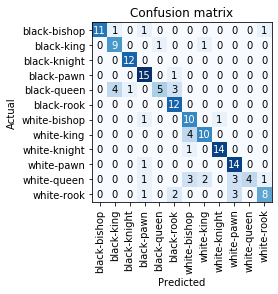

In [9]:
easy_test_dl = learn.dls.test_dl(get_image_files(test_path_easy), 
                                 with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, 
                                                  dl = easy_test_dl)

interp.print_classification_report()

interp.plot_confusion_matrix()

### More fitting

In [17]:
with learn.no_logging(): learn.fine_tune(20)

              precision    recall  f1-score   support

black-bishop       1.00      1.00      1.00        14
  black-king       0.77      0.91      0.83        11
black-knight       1.00      0.75      0.86        12
  black-pawn       0.89      1.00      0.94        16
 black-queen       0.92      0.85      0.88        13
  black-rook       1.00      1.00      1.00        12
white-bishop       0.92      1.00      0.96        12
  white-king       1.00      0.79      0.88        14
white-knight       0.83      1.00      0.91        15
  white-pawn       0.88      1.00      0.94        15
 white-queen       1.00      0.64      0.78        14
  white-rook       0.88      1.00      0.93        14

    accuracy                           0.91       162
   macro avg       0.92      0.91      0.91       162
weighted avg       0.92      0.91      0.91       162



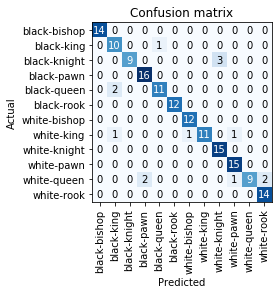

In [18]:
easy_test_dl = learn.dls.test_dl(get_image_files(test_path_easy), 
                                 with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, 
                                                  dl = easy_test_dl)

interp.print_classification_report()

interp.plot_confusion_matrix()

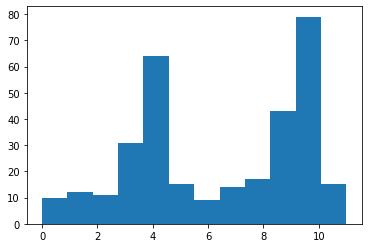

In [27]:
tmp = []
for _ in range(10):
    x, y = learn.dls[0].one_batch()
    tmp += y.detach().tolist()
plt.hist(tmp, bins=12);

In [31]:
list(enumerate(learn.dls.vocab))

[(0, 'black-bishop'),
 (1, 'black-king'),
 (2, 'black-knight'),
 (3, 'black-pawn'),
 (4, 'black-queen'),
 (5, 'black-rook'),
 (6, 'white-bishop'),
 (7, 'white-king'),
 (8, 'white-knight'),
 (9, 'white-pawn'),
 (10, 'white-queen'),
 (11, 'white-rook')]